In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM = 100
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/",
    label_mode = None,
    image_size = (IM_SHAPE[0], IM_SHAPE[1]),
    batch_size = BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [4]:
def preprocess(image):
    return tf.cast(image, dtype = tf.float32)/127.5 - 1.0

In [5]:
train_data = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
for d in train_data.take(1):
    print(d.shape)

(128, 64, 64, 3)


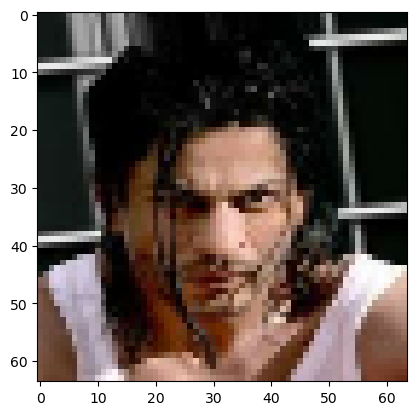

In [7]:
plt.imshow((d[3]+1)/2)

In [8]:
from tensorflow.keras.layers import (Input, Dense, Conv2DTranspose, Reshape, 
                                     LeakyReLU, BatchNormalization, Flatten, Conv2D)

In [9]:
generator = tf.keras.Sequential([
    Input(shape = (LATENT_DIM,)),
    Dense(4*4*LATENT_DIM,),
    Reshape((4,4,LATENT_DIM)),
    
    Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2DTranspose(3, kernel_size = 4, strides = 2, activation = tf.keras.activations.tanh, padding = 'same'),
], name = 'generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

In [10]:
discriminator = tf.keras.Sequential([
    Input(shape = (IM_SHAPE[0],IM_SHAPE[1], IM_SHAPE[2])),
    
    Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
#     BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    
    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),
    
    Flatten(),
    Dense(1, activation = 'sigmoid')
    
], name = 'discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [11]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, d_optimizer, g_optimizer, loss_fun):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss = loss_fun
        self.d_loss_mat = tf.keras.metrics.Mean(name = 'd_loss')
        self.g_loss_mat = tf.keras.metrics.Mean(name = 'g_loss')
        
    @property
    def metrics(self):
        return [self.d_loss_mat, self.g_loss_mat]
    
    def train_step(self, real_img):
        batch_size = tf.shape(real_img)[0]
        random_noise = tf.random.normal(shape = (batch_size, LATENT_DIM))
        fake_imgs = self.generator(random_noise)
        real_labels = tf.ones((batch_size, 1)) + 0.25*tf.random.uniform((batch_size, 1), minval = -1, maxval = 1)
        fake_labels = tf.zeros((batch_size, 1)) + 0.25*tf.random.uniform((batch_size, 1),)
        
        with tf.GradientTape() as recorder:
            real_pred = self.discriminator(real_img)
            d_loss_real = self.loss(real_labels, real_pred)
            
            fake_pred = self.discriminator(fake_imgs)
            d_loss_fake = self.loss(fake_labels, fake_pred)
            
            d_loss = d_loss_real + d_loss_fake
        partial_derivatives = recorder.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))
        
        ###########
        
        random_noise = tf.random.normal(shape = (batch_size, LATENT_DIM))
#         fake_imgs = self.generator(random_noise)
        flipped_fake_labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as recorder:
        
            fake_pred = self.discriminator(self.generator(random_noise))
            g_loss = self.loss(flipped_fake_labels, fake_pred)
            
        partial_derivatives = recorder.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))
        
        self.d_loss_mat.update_state(d_loss)
        self.g_loss_mat.update_state(g_loss)
        
        return {'g_loss':self.g_loss_mat.result(),
                'd_loss':self.d_loss_mat.result()}

In [12]:
gan = GAN(generator, discriminator)
gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.5),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.5),
    loss_fun = tf.keras.losses.BinaryCrossentropy()
)

In [13]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim = 100):
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs = None):
        n = 6
        k = 0
        out = self.model.generator(tf.random.normal(shape = (64, self.latent_dim)))
        plt.figure(figsize = (16, 16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n, n, k+1)
                plt.imshow((out[k]+1)/2,)
                plt.axis('off')
                k+=1
        plt.savefig("gen_images_epoch_{}.png".format(epoch))

In [ ]:
history = gan.fit(train_data.take(10), epochs = EPOCHS, callbacks = [ShowImage(LATENT_DIM)])

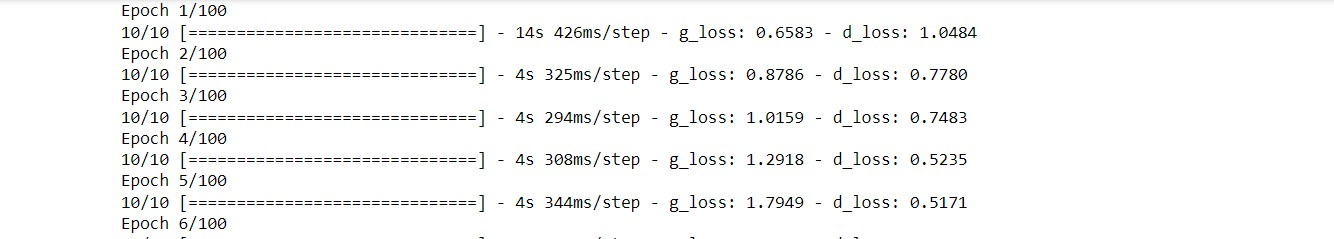

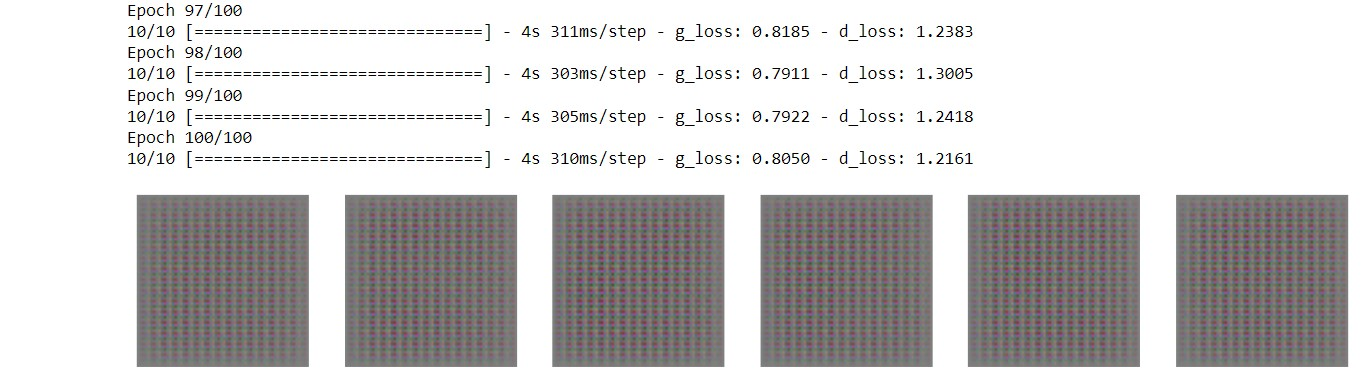

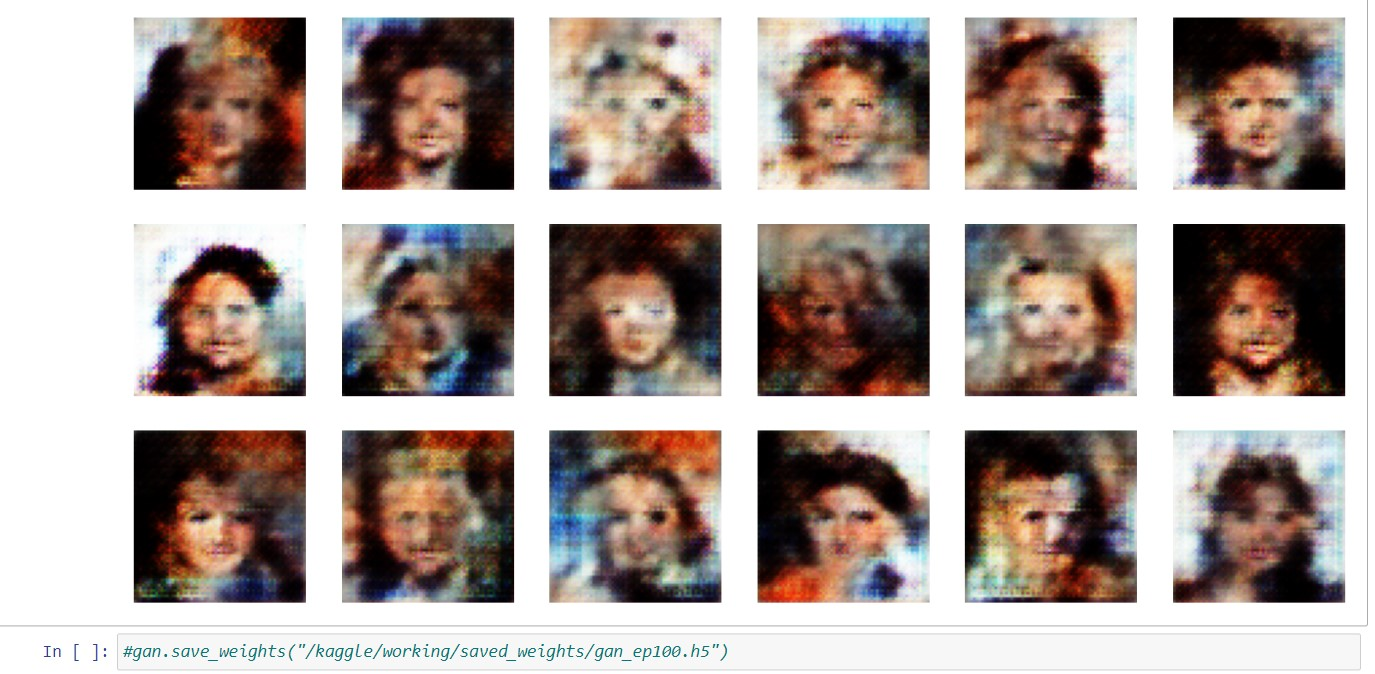

In [ ]:
#gan.save_weights("/kaggle/working/saved_weights/gan_ep100.h5")